## Stock Price Prediction and GameStop Short Squeeze
### Grace Eunji Kim
- Background: In late January 2021, GameStop (GME), a video game retailer, became the center of a financial phenomenon known as a 'short squeeze.' This occurred when a surge of retail investors, coordinating through social media platforms like Reddit's r/wallstreetbets, began buying up GameStop's stock. This drove up the stock price dramatically, which in turn inflicted heavy losses on hedge funds and other investors who had bet against the stock by short-selling it. The event drew widespread media attention, sparked controversy over stock market practices, and led to hearings in the U.S. Congress.
- Objective: To build a stock price prediction model incorporating both historical data and social media sentiment, evaluate its accuracy on the GameStop short squeeze, and analyze potential improvements based on the event.

In [884]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Stock data
from pandas_datareader import data as pdr #read data from yahoo finance api
import yfinance as yf
import datetime

# NLP
import spacy
from collections import Counter
#from wordcloud import WordCloud, STOPWORDS
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
import gensim.models

# PyTorch
import torch
torch.use_deterministic_algorithms(True)  # to help make code deterministic
torch.backends.cudnn.benchmark = False  # to help make code deterministic
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary

# Tensorflow
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import initializers, preprocessing
# import tensorflow_hub as hub
# from tensorflow.keras.applications.xception import Xception
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# Sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import pickle
import random
np.random.seed(0)  # to help make code deterministic
torch.manual_seed(0)  # to help make code deterministic
random.seed(0)  # to help make code deterministic

import warnings
warnings.filterwarnings("ignore")

## Data Acquisition
- Select relevant historical data for GameStop (stock prices, trading volume, financial ratios) over the past year. Gather social media sentiment data from Twitter and Reddit platforms, focusing on discussions related to GameStop during the chosen period.
- Feature Engineering: Preprocess and transform the historical data and social media sentiment data into features suitable for modeling. Explore text analysis techniques to quantify sentiment from Reddit and Twitter data.

In [885]:
# Import stock data
yf.pdr_override()
stock = 'GameStop'
stock_ticker = 'GME'
stock_start_date = datetime.date(2021,1,1)
stock_end_date = datetime.date(2021,9,1)

# Fetch the stock price from Yahoo Finance
stock_df = pdr.get_data_yahoo(stock_ticker, start=stock_start_date, end=stock_end_date)
stock_price = stock_df[['Close']].copy()
stock_price

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2021-01-04,4.312500
2021-01-05,4.342500
2021-01-06,4.590000
2021-01-07,4.520000
2021-01-08,4.422500
...,...
2021-08-25,49.912498
2021-08-26,51.305000
2021-08-27,51.237499


In [886]:
# Train-test split for time series
train_start_date = '2021-01-01'
train_end_date = '2021-05-31'
test_start_date = '2021-06-01'
test_end_date = '2021-08-31'
train_data = stock_price[train_start_date:train_end_date]
test_data = stock_price[test_start_date:test_end_date]

# Change data type
stock = stock_df[["Close"]].values.astype('float32')
train = train_data[["Close"]].values.astype('float32')
test = test_data[["Close"]].values.astype('float32')
train[:5]

array([[4.3125],
       [4.3425],
       [4.59  ],
       [4.52  ],
       [4.4225]], dtype=float32)

In [887]:
# Normalize
scaler = MinMaxScaler(feature_range=(0, 1))
stock_scaled = scaler.fit_transform(stock)
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.fit_transform(test)

print("Train size:", len(train_scaled))
print("Test size:", len(test_scaled))
print(train_scaled[:5])

Train size: 102
Test size: 65
[[0.        ]
 [0.00036335]
 [0.00336099]
 [0.00251317]
 [0.00133229]]


In [888]:
def create_sequence(dataset, lookback):
    """
        Transform a time series into a prediction dataset
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []

    for i in range(len(dataset) - lookback):
        X.append(dataset[i:(i+lookback)])
        y.append(dataset[(i+1):(i+lookback+1)])
    return np.array(X), np.array(y)

In [889]:
lookback = 4
X_train, y_train = create_sequence(train_scaled, lookback)
X_test, y_test = create_sequence(test_scaled, lookback)
X_train, y_train = torch.tensor(X_train), torch.tensor(y_train)
X_test, y_test = torch.tensor(X_test), torch.tensor(y_test)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([98, 4, 1]) torch.Size([98, 4, 1])
torch.Size([61, 4, 1]) torch.Size([61, 4, 1])


# Model Building
- Time-series forecasting: This model will focus on historical stock price data, employing neural network architectures like LSTMs or other RNN-based architectures to capture sequential patterns and long-term dependencies.

In [890]:
# Model architecture
class LSTM(nn.Module):
    # input_size: The number of input features for each time step.
    # hidden_size: The number of hidden units in each LSTM layer.
    # num_layers: The number of stacked LSTM layers.
    # output_size: The size of the output (e.g., the number of predicted values).

    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)   

    def forward(self, x):        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.linear(out)
        return out

In [891]:
# parameters
input_size = 1
hidden_size = 50
num_layers = 3
output_size = 1
learning_rate = 0.001
num_epochs = 500
batch_size = 16

# initialize model, optimizer, loss function
model = LSTM(input_size, hidden_size, num_layers, output_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()
model

LSTM(
  (lstm): LSTM(1, 50, num_layers=3, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [892]:
def train_model(X_train, y_train, X_test, y_test, batch_size, model, num_epochs, print_epoch):

    # Create dataloader
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    train_hist = []
    test_hist = []

    # Training Loop
    for epoch in range(num_epochs):
        total_loss = 0.0

        # Training
        model.train()
        for X_batch, y_batch in train_loader:
            # make predictions for current batch and compute loss
            preds = model(X_batch)        
            loss = loss_fn(preds, y_batch)

            # update model parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        # Calculate average training loss and accuracy
        average_loss = total_loss / len(train_loader)
        train_hist.append(average_loss)

        # Evaluation
        model.eval()
        with torch.no_grad():
            total_test_loss = 0.0
            
            for batch_X_test, batch_y_test in test_loader:
                preds_test = model(batch_X_test)
                test_loss = loss_fn(preds_test, batch_y_test)
    
                total_test_loss += test_loss.item()

            # Calculate average test loss and accuracy
            average_test_loss = total_test_loss / len(test_loader)
            test_hist.append(average_test_loss)
        
        # Print
        if print_epoch==True and (epoch+1)%10==0:
            print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')
            
    return train_hist, test_hist

In [893]:
train_hist, test_hist = train_model(X_train, y_train, X_test, y_test, batch_size, model, num_epochs, print_epoch=True)

Epoch [10/500] - Training Loss: 0.0534, Test Loss: 0.0506


Epoch [20/500] - Training Loss: 0.0231, Test Loss: 0.0243
Epoch [30/500] - Training Loss: 0.0150, Test Loss: 0.0144
Epoch [40/500] - Training Loss: 0.0170, Test Loss: 0.0110
Epoch [50/500] - Training Loss: 0.0104, Test Loss: 0.0107
Epoch [60/500] - Training Loss: 0.0095, Test Loss: 0.0098
Epoch [70/500] - Training Loss: 0.0092, Test Loss: 0.0102
Epoch [80/500] - Training Loss: 0.0085, Test Loss: 0.0095
Epoch [90/500] - Training Loss: 0.0091, Test Loss: 0.0098
Epoch [100/500] - Training Loss: 0.0111, Test Loss: 0.0098
Epoch [110/500] - Training Loss: 0.0083, Test Loss: 0.0104
Epoch [120/500] - Training Loss: 0.0082, Test Loss: 0.0102
Epoch [130/500] - Training Loss: 0.0120, Test Loss: 0.0104
Epoch [140/500] - Training Loss: 0.0080, Test Loss: 0.0111
Epoch [150/500] - Training Loss: 0.0077, Test Loss: 0.0116
Epoch [160/500] - Training Loss: 0.0088, Test Loss: 0.0113
Epoch [170/500] - Training Loss: 0.0085, Test Loss: 0.0121
Epoch [180/500] - Training Loss: 0.0080, Test Loss: 0.0130
Epoch

In [894]:
def plot_learning_curve():
    # Plot Learning Curve
    x = np.linspace(1, num_epochs, num_epochs)
    plt.plot(x, train_hist, scalex=True, label="Training loss")
    plt.plot(x, test_hist, label="Test loss")
    plt.legend()
    plt.show()

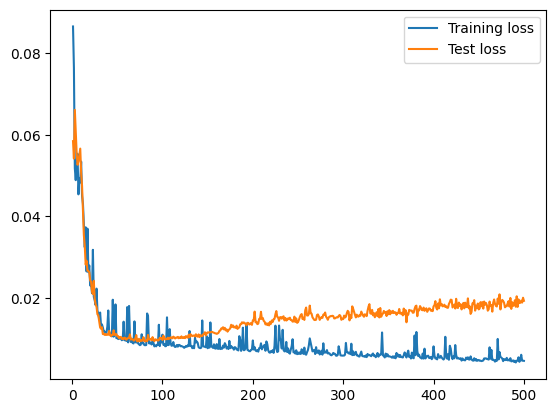

In [895]:
plot_learning_curve()

In [896]:
def get_test_points(dataset, scaler, inverse_transform):
    # shift test predictions for plotting
    with torch.no_grad():    
        test_points = np.ones(len(dataset)) * np.nan
        test_points[len(train)+lookback:len(dataset)] = model(X_test)[:, -1, :].reshape(-1)
        if inverse_transform==True:
            test_points = scaler.inverse_transform(test_points.reshape(1,-1)).reshape(-1,1)
    return test_points

In [897]:
def evaluate_model(test_points, lookback):
    # Evaluate forecast
    length = len(test) - lookback
    model_results = {'MSE': [], 'RMSE': [], 'MAE': []}
    model_results['MSE'].append(mean_squared_error(test[-length:,-1], test_points[-length:]))
    model_results['RMSE'].append(np.sqrt((mean_squared_error(test[-length:,-1], test_points[-length:]))))
    model_results['MAE'].append(mean_absolute_error(test[-length:,-1], test_points[-length:]))
    return model_results

In [898]:
test_points = get_test_points(stock_price, scaler, inverse_transform=True)
model_results = evaluate_model(test_points, lookback)

In [899]:
def plot_predictions(dataset, train, test, title):
    plt.figure(figsize=(14, 8), dpi=100)
    plt.plot(train_data.index, train, c='blue', label='Original Closing Price (train)') 
    plt.plot(test_data.index, test, c='green', label='Original Closing Price (test)') 
    plt.plot(dataset.index, test_points, c='red', label='Predicted Values')
    plt.axvline(dataset.index[len(train)], c='orange', linestyle='--', label='Train-Test Split')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

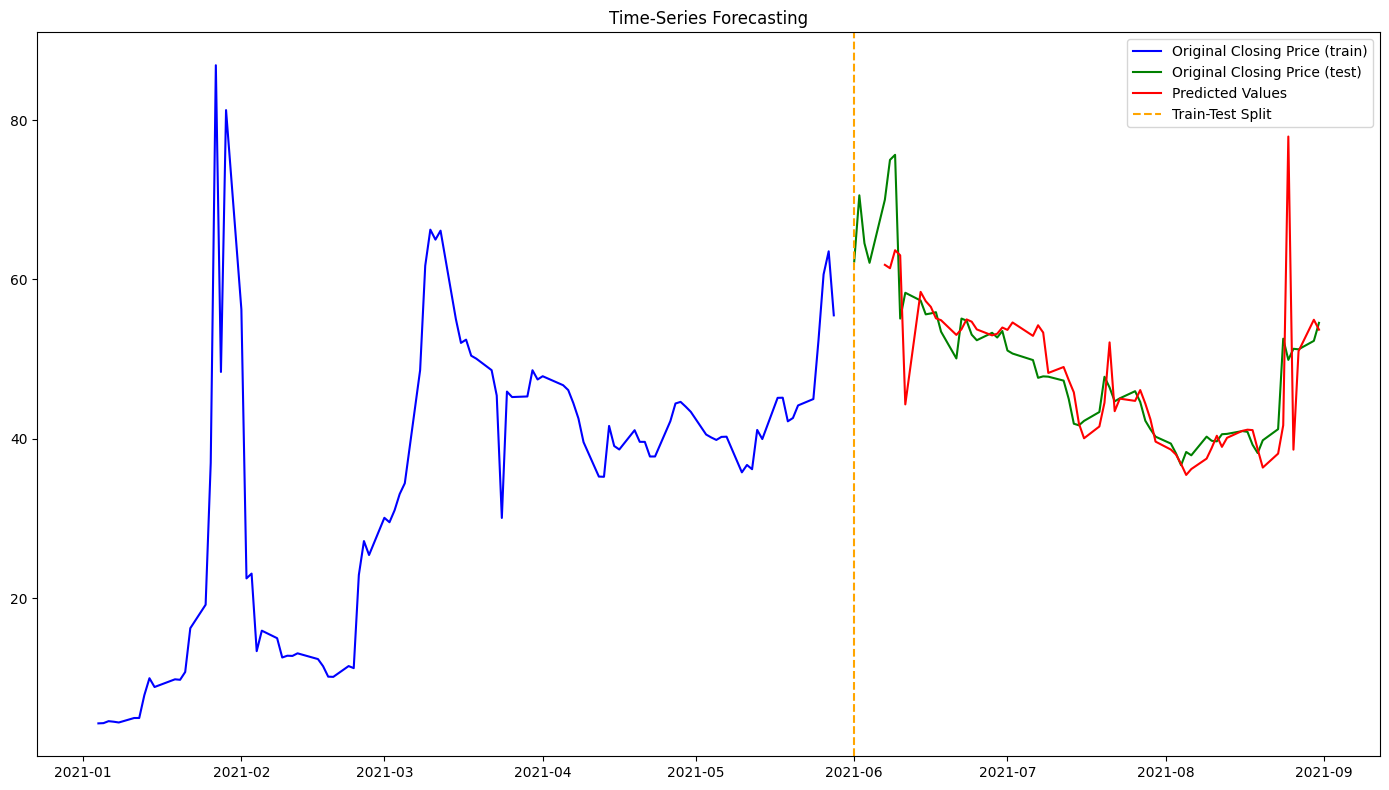

In [900]:
plot_predictions(stock_price, train, test, title='Time-Series Forecasting')

## Sentiment Analysis
- This model will leverage social media data related to GameStop, utilizing text analysis techniques like sentiment lexicons, topic modeling, or word embeddings to quantify sentiment scores and extract relevant features.
[If you have existing data or models that compute the sentiment for the period you can use these directly instead of building a separate sentiment model]

In [901]:
gme_raw = pd.read_csv('rGME_dataset_features.csv', index_col=0)

In [902]:
gme_raw.head()

,id,title,url,score,author,num_comments,date,flair,compound,neg,...,_poss,_intj,_appos,_npadvmod,_predet,_case,_expl,_oprd,_dative,_nmod
0,kqfajb,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,https://www.reddit.com/r/GME/comments/kqfajb/y...,1.0,TitsDownOnly,9.0,2021-01-04,NaN,0.9872,0.000,...,0,0,6,0,0,0,0,0,0,0
1,kqjh2t,Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀,/r/wallstreetbets/comments/kqcwdo/gamestops_gr...,1.0,zoomermoney,1.0,2021-01-04,NaN,0.9906,0.000,...,0,0,3,0,0,0,0,0,0,0
2,kqvp7l,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,https://www.reddit.com/r/GME/comments/kqvp7l/t...,1.0,TitsDownOnly,6.0,2021-01-05,NaN,0.5319,0.000,...,0,0,0,0,0,0,0,0,0,0
3,krcwch,You already know what we must do brothers and ...,/r/wallstreetbets/comments/kr98ym/gme_gang_we_...,1.0,dontforgettolive,4.0,2021-01-05,NaN,-0.2960,0.115,...,1,0,0,0,0,0,0,0,0,0
4,krnthg,ICR conference (11th Jan),https://www.reddit.com/r/GME/comments/krnthg/i...,1.0,nicky94,10.0,2021-01-06,NaN,0.0000,0.000,...,0,0,0,1,0,0,0,0,0,0


In [903]:
gme_df = gme_raw[['date','compound','pos','neu','neg']]
test_end_date = '2021-08-31'
gme_df = gme_df[gme_df['date'] <= test_end_date]
gme_df[:20]

,date,compound,pos,neu,neg
0,2021-01-04,0.9872,0.811,0.189,0.000
1,2021-01-04,0.9906,0.921,0.079,0.000
2,2021-01-05,0.5319,0.256,0.744,0.000
3,2021-01-05,-0.2960,0.000,0.885,0.115
4,2021-01-06,0.0000,0.000,1.000,0.000
5,2021-01-06,0.7777,0.377,0.516,0.107
6,2021-01-10,0.9667,0.608,0.392,0.000
7,2021-01-11,0.0000,0.000,1.000,0.000
8,2021-01-11,0.0000,0.000,1.000,0.000
9,2021-01-11,0.9517,0.577,0.423,0.000


In [904]:
gme_daily = gme_df.groupby('date').mean().reset_index()
gme_daily

,date,compound,pos,neu,neg
0,2021-01-04,0.988900,0.866000,0.134000,0.000000
1,2021-01-05,0.117950,0.128000,0.814500,0.057500
2,2021-01-06,0.388850,0.188500,0.758000,0.053500
3,2021-01-10,0.966700,0.608000,0.392000,0.000000
4,2021-01-11,0.237925,0.144250,0.855750,0.000000
...,...,...,...,...,...
216,2021-08-27,0.136975,0.133268,0.803986,0.062746
217,2021-08-28,0.157799,0.122748,0.834839,0.042419
218,2021-08-29,0.147067,0.146374,0.808175,0.045444
219,2021-08-30,0.123952,0.119468,0.826172,0.054340


In [905]:
gme_daily['sentiment_class'] = pd.cut(gme_daily['compound'], bins=[-1, -0.1, 0.1, 1], labels=['Negative','Neutral','Positive'])
gme_daily

,date,compound,pos,neu,neg,sentiment_class
0,2021-01-04,0.988900,0.866000,0.134000,0.000000,Positive
1,2021-01-05,0.117950,0.128000,0.814500,0.057500,Positive
2,2021-01-06,0.388850,0.188500,0.758000,0.053500,Positive
3,2021-01-10,0.966700,0.608000,0.392000,0.000000,Positive
4,2021-01-11,0.237925,0.144250,0.855750,0.000000,Positive
...,...,...,...,...,...,...
216,2021-08-27,0.136975,0.133268,0.803986,0.062746,Positive
217,2021-08-28,0.157799,0.122748,0.834839,0.042419,Positive
218,2021-08-29,0.147067,0.146374,0.808175,0.045444,Positive
219,2021-08-30,0.123952,0.119468,0.826172,0.054340,Positive


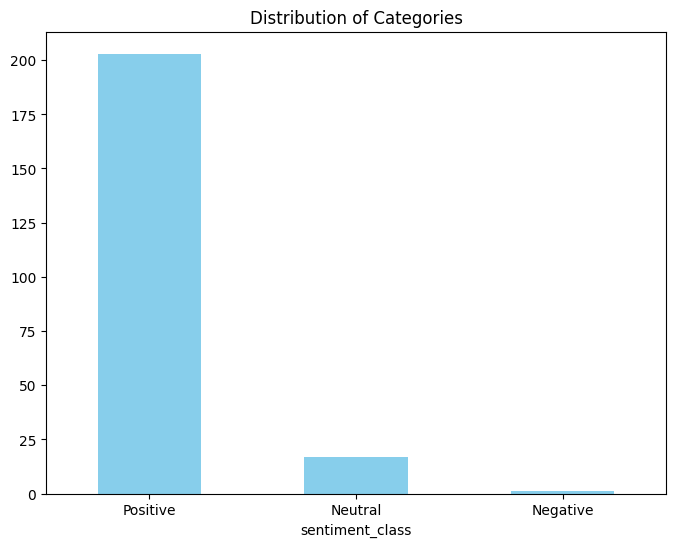

In [906]:
category_counts = gme_daily['sentiment_class'].value_counts()
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Categories')
plt.xticks(rotation=0)
plt.show()

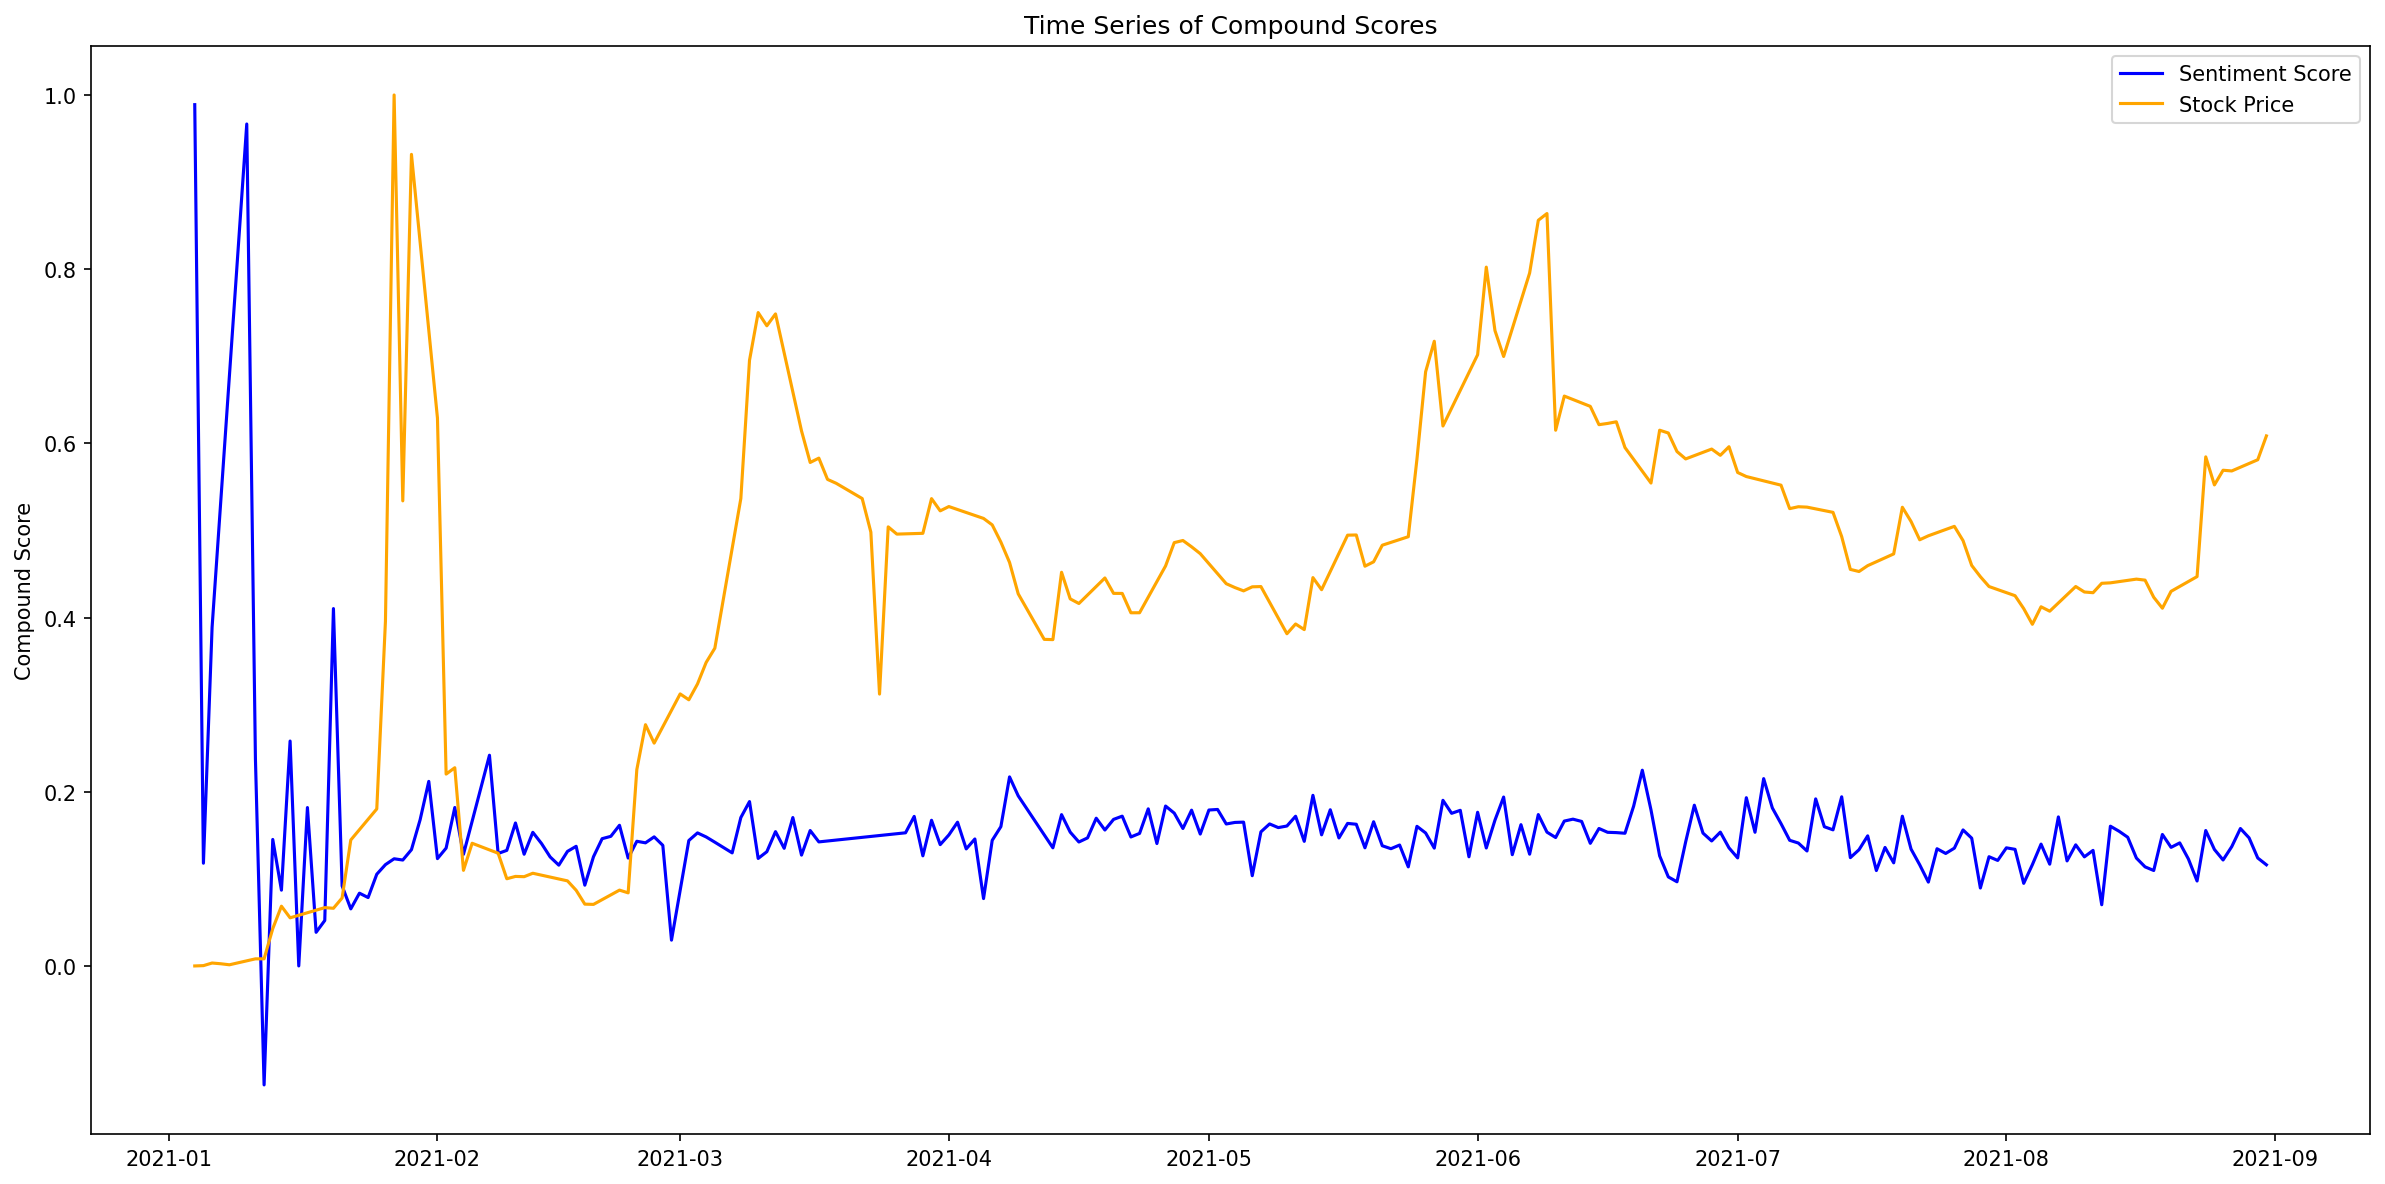

In [907]:
gme_daily.index = pd.to_datetime(gme_daily['date'])

# Plot the time series of compound scores
plt.figure(figsize=(16, 8), dpi=150)
plt.plot(gme_daily.index, gme_daily['compound'], color='blue', label='Sentiment Score')
plt.plot(stock_df.index, stock_scaled, label='Stock Price', color='orange')
plt.title('Time Series of Compound Scores')
plt.ylabel('Compound Score')
plt.legend()
plt.tight_layout()
plt.show()

## Model fusion
- This model will combine the predictions from both the time-series forecasting and sentiment analysis to perform the final predictions.

In [908]:
merged_df = gme_daily[['date','compound']].merge(stock_price, how='left', left_index=True, right_index=True)
merged_df = merged_df.dropna()
merged_df = merged_df.drop(columns={'date'})
merged_df

,compound,Close
date,,
2021-01-04,0.988900,4.312500
2021-01-05,0.117950,4.342500
2021-01-06,0.388850,4.590000
2021-01-11,0.237925,4.985000
2021-01-12,-0.136600,4.987500
...,...,...
2021-08-25,0.133748,49.912498
2021-08-26,0.121672,51.305000
2021-08-27,0.136975,51.237499


In [909]:
# Train-test split for time series
train_start_date = '2021-01-01'
train_end_date = '2021-05-31'
test_start_date = '2021-06-01'
test_end_date = '2021-08-31'
train_data = merged_df[train_start_date:train_end_date]
test_data = merged_df[test_start_date:test_end_date]

# Change data type
train = train_data.values.astype('float32')
test = test_data.values.astype('float32')
train[:5]

array([[ 0.9889  ,  4.3125  ],
       [ 0.11795 ,  4.3425  ],
       [ 0.38885 ,  4.59    ],
       [ 0.237925,  4.985   ],
       [-0.1366  ,  4.9875  ]], dtype=float32)

In [910]:
def create_sequence_2(X, y, lookback):
    X_data, y_data = [], []
    for i in range(len(X) - lookback):
        X_data.append(X[i:(i + lookback)])
        y_data.append(y[(i):(i+lookback)])
    return np.array(X_data), np.array(y_data)

In [911]:
def data_preprocessing(train, test, lookback):
    # Create sequence
    X_train, y_train = create_sequence_2(train, train[:, 1], lookback)
    X_test, y_test = create_sequence_2(test, test[:, 1], lookback)
    #print(X_train.shape, y_train.shape)
    #print(X_test.shape, y_test.shape)
    print(X_test[:5])

    # Normalize
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, 2)).reshape(-1, lookback, 2)
    X_test_scaled = scaler_X.transform(X_test.reshape(-1, 2)).reshape(-1, lookback, 2)
    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1, lookback, 1)
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1, lookback, 1)
    #print(X_train_scaled.shape, y_train_scaled.shape)
    #print(X_train_scaled[:2])

    # Convert to tensor
    X_train, y_train = torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train_scaled, dtype=torch.float32)
    X_test, y_test = torch.tensor(X_test_scaled, dtype=torch.float32), torch.tensor(y_test_scaled, dtype=torch.float32)
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

    return X_train, y_train, X_test, y_test, scaler_y

In [912]:
# parameters
input_size = 2 # Now the input is 2

# initialize model, optimizer, loss function
model = LSTM(input_size, hidden_size, num_layers, output_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()
model

LSTM(
  (lstm): LSTM(2, 50, num_layers=3, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [913]:
X_train, y_train, X_test, y_test, scaler_y = data_preprocessing(train, test, lookback)
train_hist, test_hist = train_model(X_train, y_train, X_test, y_test, batch_size, model, num_epochs, print_epoch=True)

[[[ 0.17644666 62.255     ]
  [ 0.13544066 70.56      ]
  [ 0.1673835  64.545     ]
  [ 0.19392973 62.09      ]]

 [[ 0.13544066 70.56      ]
  [ 0.1673835  64.545     ]
  [ 0.19392973 62.09      ]
  [ 0.12832911 70.0025    ]]

 [[ 0.1673835  64.545     ]
  [ 0.19392973 62.09      ]
  [ 0.12832911 70.0025    ]
  [ 0.17379016 75.        ]]

 [[ 0.19392973 62.09      ]
  [ 0.12832911 70.0025    ]
  [ 0.17379016 75.        ]
  [ 0.15362951 75.64      ]]

 [[ 0.12832911 70.0025    ]
  [ 0.17379016 75.        ]
  [ 0.15362951 75.64      ]
  [ 0.14745587 55.0975    ]]]
torch.Size([86, 4, 2]) torch.Size([86, 4, 1])
torch.Size([61, 4, 2]) torch.Size([61, 4, 1])
Epoch [10/500] - Training Loss: 0.0519, Test Loss: 0.0550
Epoch [20/500] - Training Loss: 0.0273, Test Loss: 0.0162
Epoch [30/500] - Training Loss: 0.0088, Test Loss: 0.0022
Epoch [40/500] - Training Loss: 0.0017, Test Loss: 0.0009
Epoch [50/500] - Training Loss: 0.0008, Test Loss: 0.0003
Epoch [60/500] - Training Loss: 0.0004, Test Los

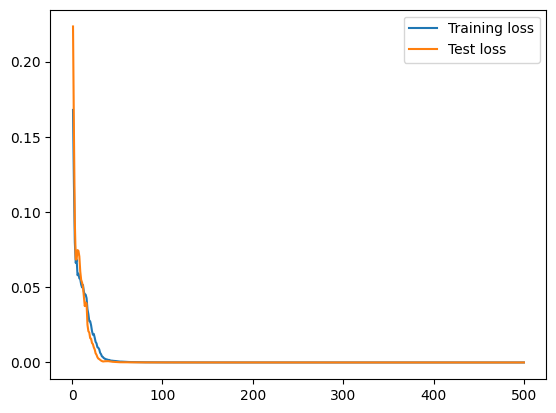

In [914]:
plot_learning_curve()

## Retrospective Predictions and Evaluation 
- Prediction Period: Apply the chosen model to predict GameStop's closing prices for the months of **June 2021 through August 2021.**
- Evaluation: Compare the predicted prices with the actual closing prices for each month. Calculate evaluation metrics like Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE) to assess the model's accuracy.
- Visualization: Analyze and visualize the discrepancies between predicted and actual prices, identifying periods of significant deviations and potential reasons for these differences.

In [915]:
test_points = get_test_points(merged_df, scaler_y, inverse_transform=True)
model_results2 = evaluate_model(test_points, lookback)
model_results2

{'MSE': [12.930650291834109],
 'RMSE': [3.5959213411633617],
 'MAE': [1.9559998368505647]}

In [916]:
combined_metrics = []
for model_metrics, model_name in zip([model_results, model_results2], ['Univariate TSF Model', 'Combined TSF Model']):
    combined_metrics_dict = {'Model': model_name}
    for metric, value_list in model_metrics.items():
        combined_metrics_dict[metric] = value_list[0]
    combined_metrics.append(combined_metrics_dict)
combined_metrics

[{'Model': 'Univariate TSF Model',
  'MSE': 32.57969207618263,
  'RMSE': 5.707862303540848,
  'MAE': 3.242274058438869},
 {'Model': 'Combined TSF Model',
  'MSE': 12.930650291834109,
  'RMSE': 3.5959213411633617,
  'MAE': 1.9559998368505647}]

In [917]:
results_df = pd.DataFrame(combined_metrics)
results_df

,Model,MSE,RMSE,MAE
0,Univariate TSF Model,32.579692,5.707862,3.242274
1,Combined TSF Model,12.930650,3.595921,1.956000


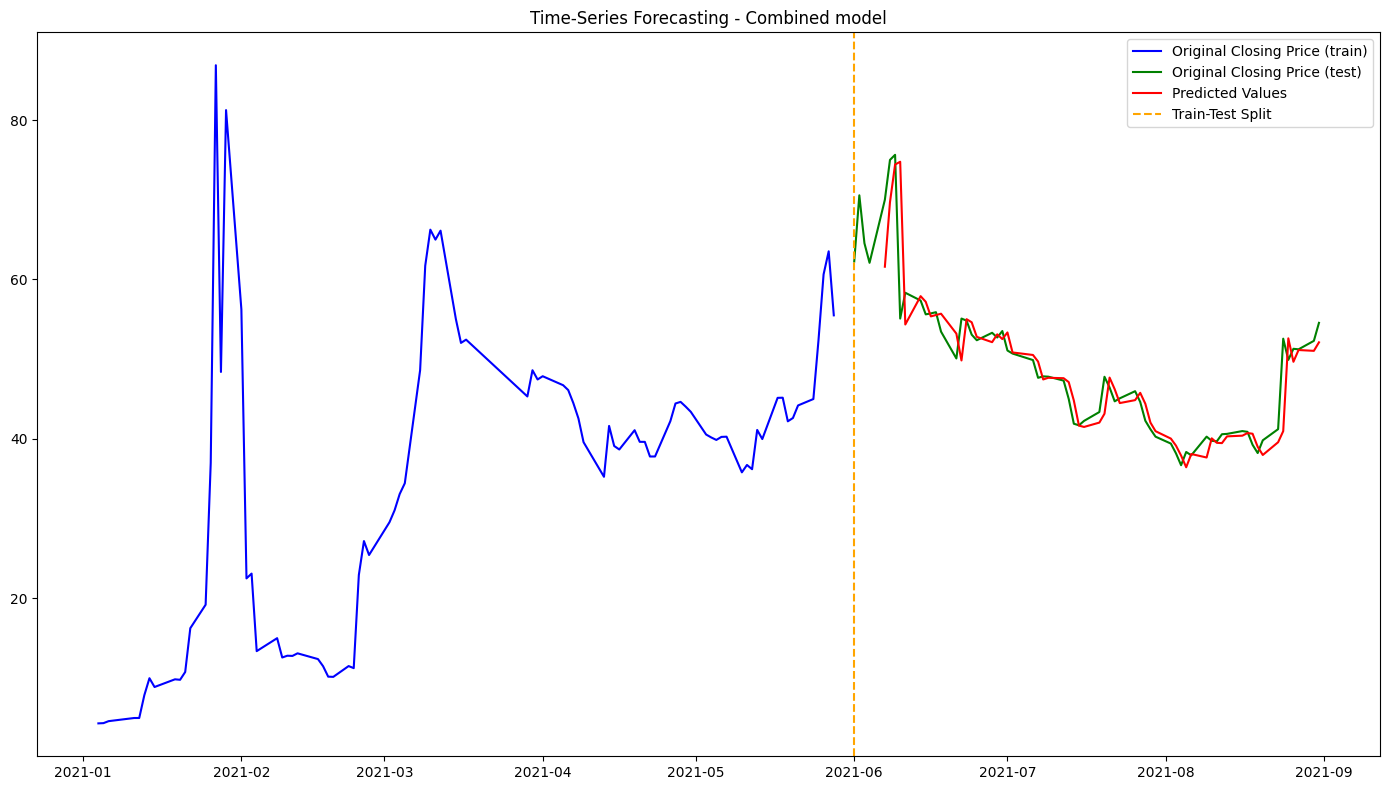

In [918]:
plot_predictions(merged_df, train[:,1], test[:,1], title='Time-Series Forecasting - Combined model')

## Model Adaptation
- Event Analysis: Explore the social media landscape surrounding the GameStop short squeeze in January 2021. Analyze the volume, sentiment, and key themes of discussions on platforms like Reddit's r/WallStreetBets to understand the event's dynamics.
- Model Sensitivity: Investigate how the model's performance would change if exposed to data with similar characteristics to the GameStop short squeeze (e.g., sudden shifts in sentiment, high volatility). Conduct sensitivity analysis by injecting simulated spikes in social media sentiment and observing the model's predictions.
[Rather than building a model, injecting simulated spikes in social media sentiment and then conducting the sensitivity analysis evaluate how good is your model in picking up generally rising or falling sentiments vs sudden spikes in sentiments. Discuss how those spikes could occur and what you may have to do to identify such spikes in the future and their impact on stock prices]
- Algorithmic Adjustments: Based on the event analysis and sensitivity analysis, propose concrete modifications to the existing model or feature engineering processes to improve its performance in capturing the impact of extreme social media sentiment on stock prices.

In [919]:
lookbacks = list(range(2,21))
pt_results = []

# for lookback in lookbacks:
#     X_train, y_train, X_test, y_test, scaler_y = data_preprocessing(train, test, lookback)
#     train_hist, test_hist = train_model(X_train, y_train, X_test, y_test, batch_size, model, num_epochs, print_epoch=False)
#     pt_results.append(test_hist)

In [920]:
# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown',
#           'teal', 'olive', 'salmon', 'lime', 'indigo', 'pink', 'cyan', 'gold', 'silver']

# plt.figure(figsize=(14, 8), dpi=100)
# for i, arr in enumerate(pt_results):
#     plt.plot(arr, color=colors[i], label=f'Looback={i+1}')

# plt.xlabel('Epochs')
# plt.ylabel('Test loss')
# plt.title('Test Loss - Hyperparameter Tuning')
# plt.legend()
# plt.tight_layout()
# plt.show()

In [921]:
# lookback = 19
# X_train, y_train, X_test, y_test, scaler_y = data_preprocessing(train, test, lookback)
# train_hist, test_hist = train_model(X_train, y_train, X_test, y_test, batch_size, model, num_epochs, print_epoch=True)

In [922]:
# test_points = get_test_points(merged_df, scaler_y, inverse_transform=True)
# plot_predictions(merged_df, train[:,1], test[:,1], title='Time-Series Forecasting - Combined model')

## SP

In [924]:
# Add spikes
test_spike = test.copy()

np.random.seed(1)
random_numbers = np.random.randint(0, 66, size=5)
test_spike[2, 0] = np.float32(1)
for i in random_numbers:
    if i % 2 != 0:
        test_spike[i, 0] = np.float32(1)
    else:
        test_spike[i, 0] = np.float32(-1)


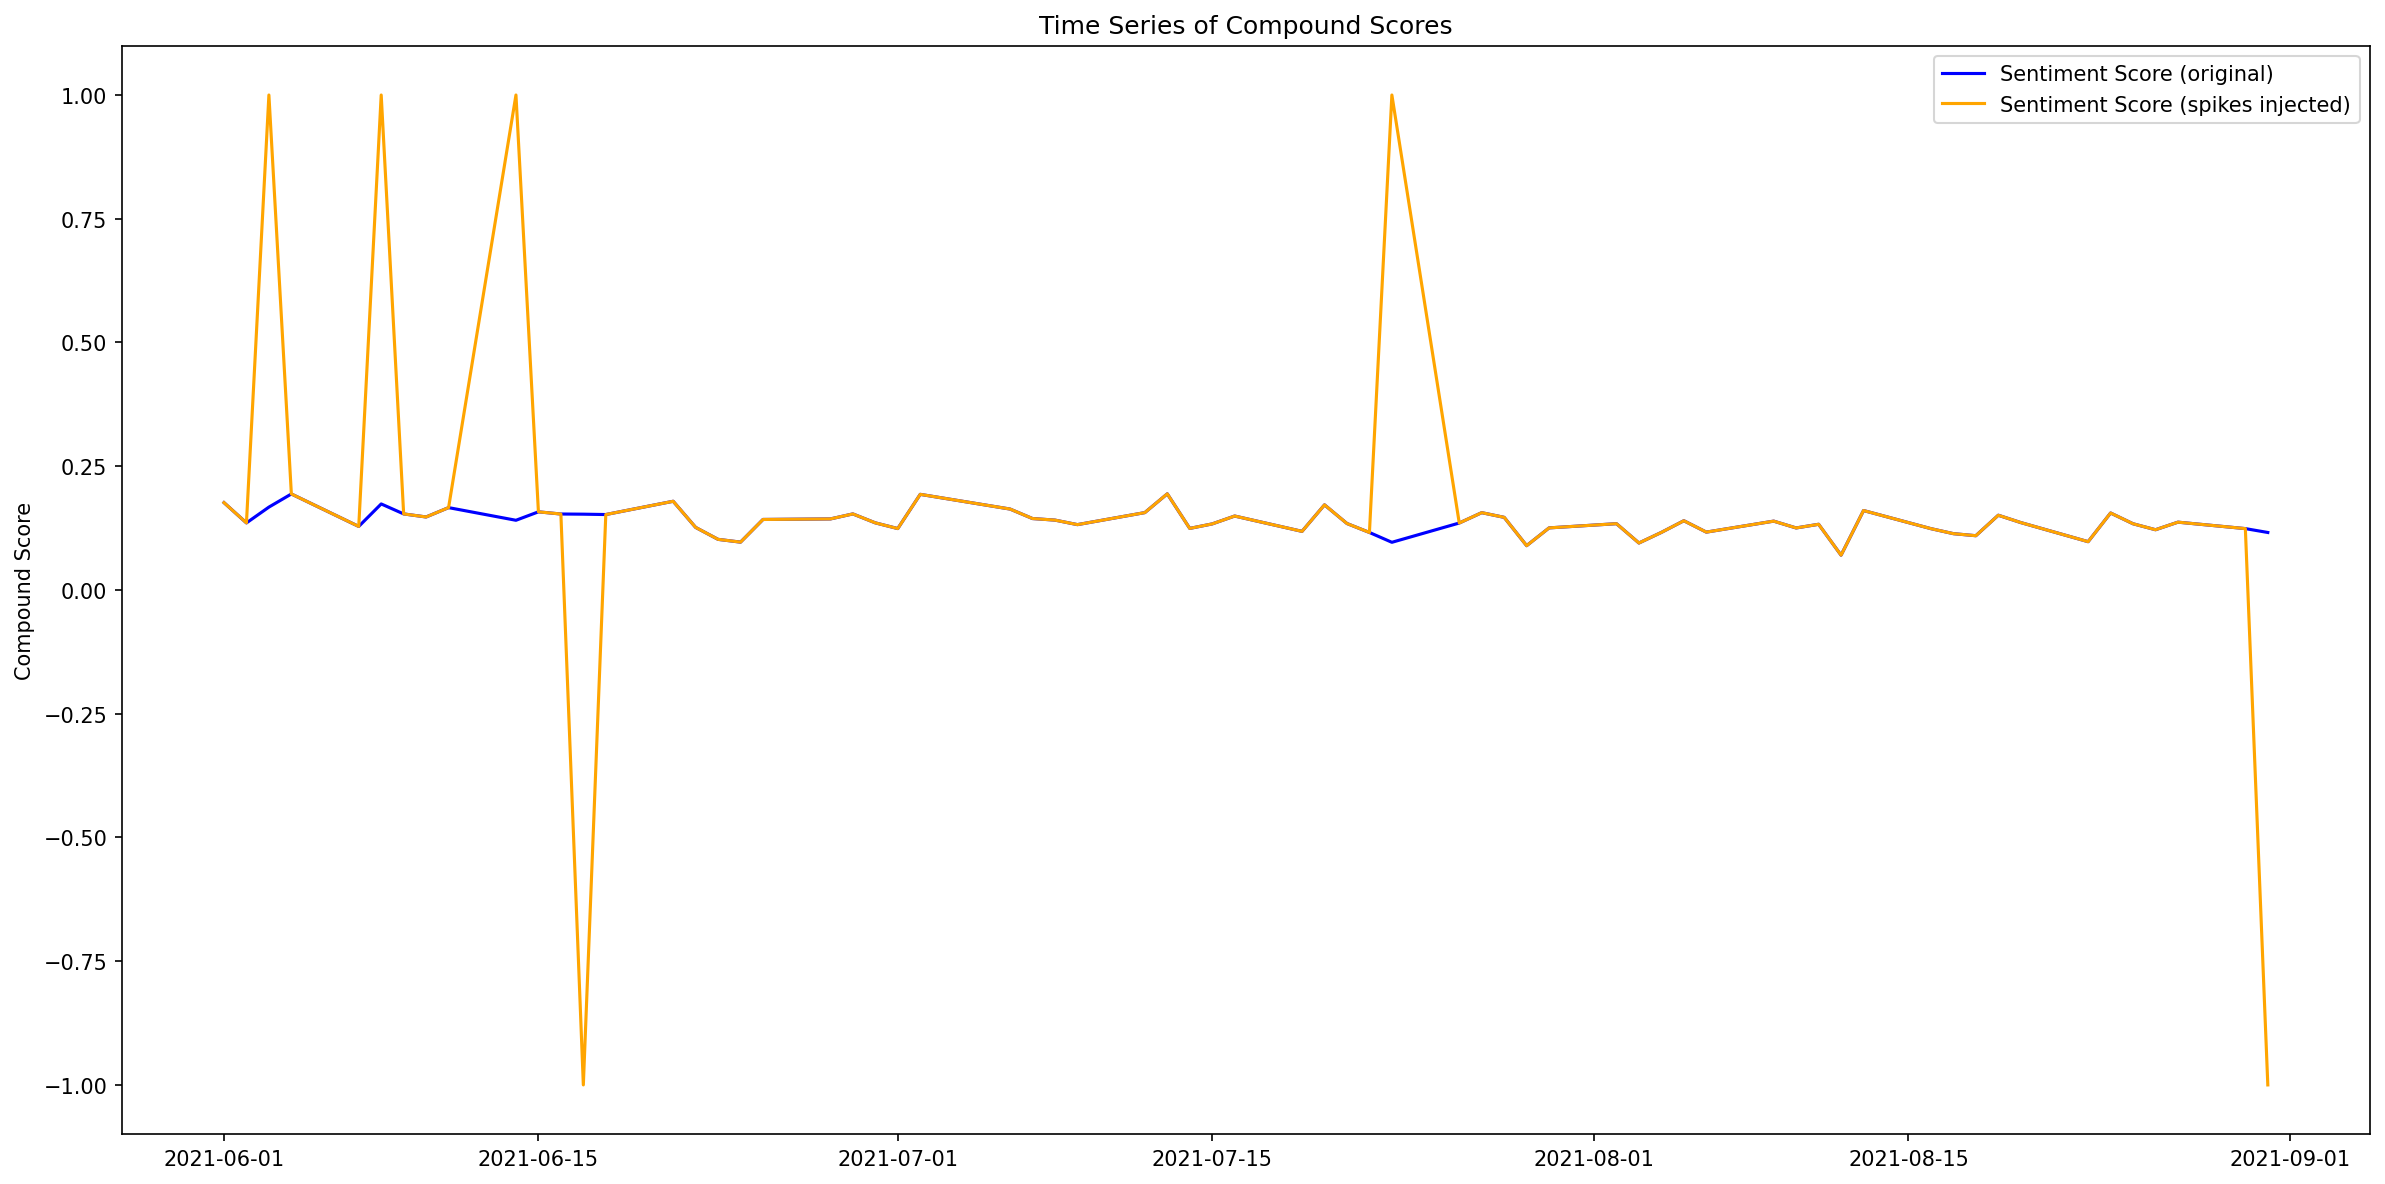

In [925]:
# Plot the time series of compound scores
plt.figure(figsize=(16, 8), dpi=150)
plt.plot(test_data.index, test[:,0], color='blue', label='Sentiment Score (original)')
plt.plot(test_data.index, test_spike[:,0], color='orange', label='Sentiment Score (spikes injected)')
plt.title('Time Series of Compound Scores')
plt.ylabel('Compound Score')
plt.legend()
plt.tight_layout()
plt.show()

In [926]:
lookback = 4

X_train, y_train, X_test, y_test, scaler_y = data_preprocessing(train, test_spike, lookback)
train_hist, test_hist = train_model(X_train, y_train, X_test, y_test, batch_size, model, num_epochs, print_epoch=True)

[[[ 0.17644666 62.255     ]
  [ 0.13544066 70.56      ]
  [ 1.         64.545     ]
  [ 0.19392973 62.09      ]]

 [[ 0.13544066 70.56      ]
  [ 1.         64.545     ]
  [ 0.19392973 62.09      ]
  [ 0.12832911 70.0025    ]]

 [[ 1.         64.545     ]
  [ 0.19392973 62.09      ]
  [ 0.12832911 70.0025    ]
  [ 1.         75.        ]]

 [[ 0.19392973 62.09      ]
  [ 0.12832911 70.0025    ]
  [ 1.         75.        ]
  [ 0.15362951 75.64      ]]

 [[ 0.12832911 70.0025    ]
  [ 1.         75.        ]
  [ 0.15362951 75.64      ]
  [ 0.14745587 55.0975    ]]]
torch.Size([86, 4, 2]) torch.Size([86, 4, 1])
torch.Size([61, 4, 2]) torch.Size([61, 4, 1])


Epoch [10/500] - Training Loss: 0.0000, Test Loss: 0.0000
Epoch [20/500] - Training Loss: 0.0000, Test Loss: 0.0000
Epoch [30/500] - Training Loss: 0.0000, Test Loss: 0.0000
Epoch [40/500] - Training Loss: 0.0000, Test Loss: 0.0000
Epoch [50/500] - Training Loss: 0.0000, Test Loss: 0.0000
Epoch [60/500] - Training Loss: 0.0000, Test Loss: 0.0000
Epoch [70/500] - Training Loss: 0.0000, Test Loss: 0.0000
Epoch [80/500] - Training Loss: 0.0000, Test Loss: 0.0000
Epoch [90/500] - Training Loss: 0.0000, Test Loss: 0.0000
Epoch [100/500] - Training Loss: 0.0000, Test Loss: 0.0000
Epoch [110/500] - Training Loss: 0.0000, Test Loss: 0.0000
Epoch [120/500] - Training Loss: 0.0000, Test Loss: 0.0000
Epoch [130/500] - Training Loss: 0.0000, Test Loss: 0.0000
Epoch [140/500] - Training Loss: 0.0000, Test Loss: 0.0000
Epoch [150/500] - Training Loss: 0.0000, Test Loss: 0.0000
Epoch [160/500] - Training Loss: 0.0000, Test Loss: 0.0000
Epoch [170/500] - Training Loss: 0.0000, Test Loss: 0.0000
Epoch 

In [927]:
test_points = get_test_points(merged_df, scaler_y, inverse_transform=False)

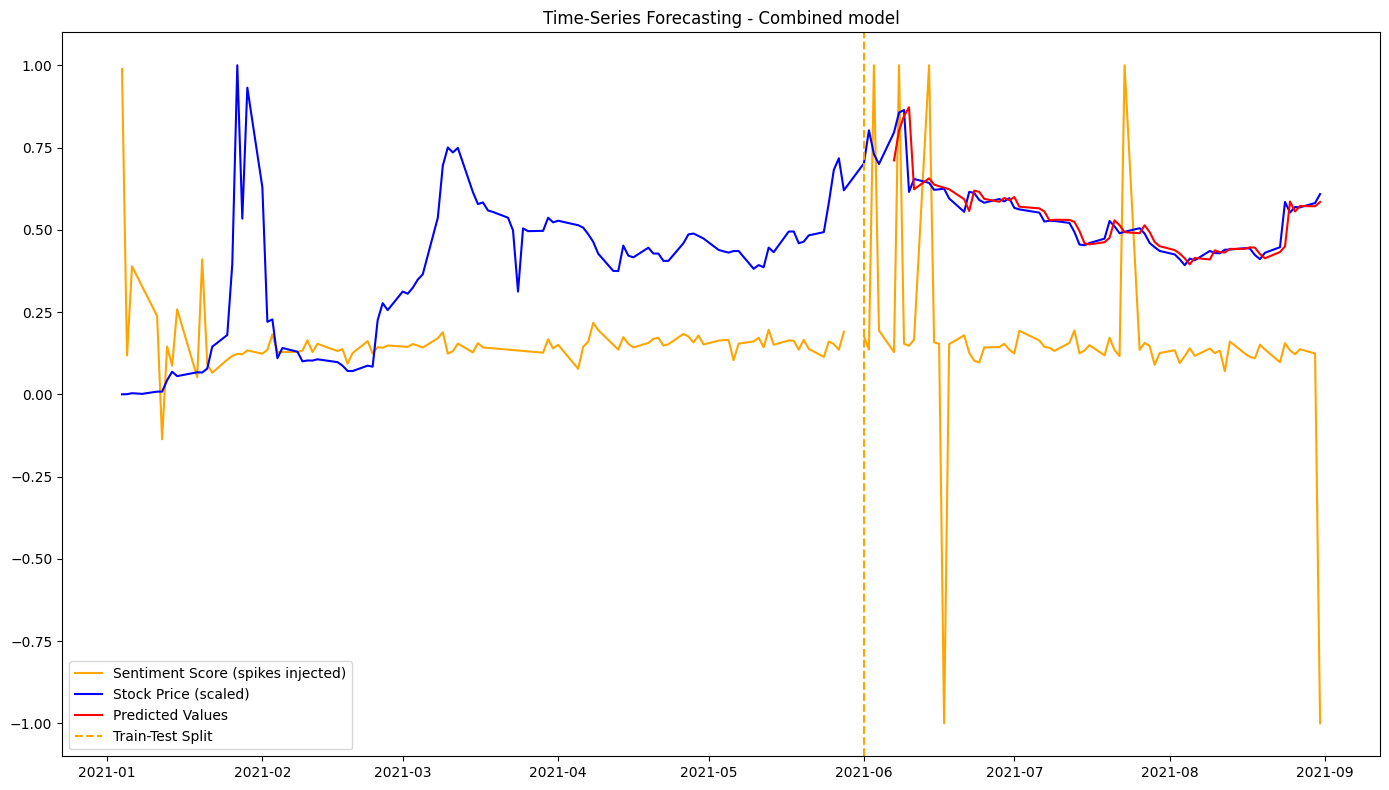

In [929]:
# plot
plt.figure(figsize=(14, 8), dpi=100)
plt.plot(train_data.index, train[:,0], color='orange')
plt.plot(test_data.index, test_spike[:,0], color='orange', label='Sentiment Score (spikes injected)')
plt.plot(stock_df.index, stock_scaled, color='blue', label='Stock Price (scaled)')
plt.plot(merged_df.index, test_points, c='red', label='Predicted Values')
plt.axvline(merged_df.index[len(train)], c='orange', linestyle='--', label='Train-Test Split')
plt.title('Time-Series Forecasting - Combined model')
plt.legend()
plt.tight_layout()
plt.show()